In [11]:
import asdf
import pyccl as ccl
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

# Abacus data
This notebook shows how we turn the raw Abacus power spectra into smooth $P(k)$ arrays to be used by CCL to produce angular power spectra.

This just returns the cosmological model of the Abacus simulation as a CCL object

In [12]:
def get_abacus_cosmo(ws8=False):
    omega_b = 0.02237
    omega_cdm = 0.12
    h = 0.6736
    A_s = 2.083e-09
    n_s = 0.9649
    sigma8 = 0.8090212289405192
    if ws8:
        cosmo = ccl.Cosmology(Omega_c=omega_cdm/h**2, Omega_b=omega_b/h**2,
                              h=h, sigma8=sigma8, n_s=n_s, m_nu=0.06)
    else:
        cosmo = ccl.Cosmology(Omega_c=omega_cdm/h**2, Omega_b=omega_b/h**2,
                              h=h, A_s=A_s, n_s=n_s, m_nu=0.06)
    cosmo.compute_linear_power()
    cosmo.compute_nonlin_power()
    return cosmo

In [29]:
cosmo = get_abacus_cosmo(True)

In [30]:
h=cosmo['h']
Oc = cosmo['Omega_c']
Ob = cosmo['Omega_b']
s8 = cosmo['sigma8']
w  = cosmo['w0']
ns = cosmo['n_s']
neff = cosmo['Neff']
#1. Set up cosmovec for anzu from CCL cosmo object
anzu_cosmo = np.atleast_2d([Ob*h**2, Oc*h**2, w, ns, s8, 100*h, neff])


In [31]:
anzu_cosmo.shape

(1, 7)

In [38]:
stackcosmo = np.vstack([anzu_cosmo for i in range(30)])
a_s = 1./(1+np.linspace(0., 4., 30)[::-1])

print(np.hstack([stackcosmo, a_s]).shape)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [36]:
a_s.shape

(30,)

In [44]:
np.vstack([stackcosmo.T, a_s]).T.shape

(30, 8)

This is a [Savitzky-Golay](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) smoothing function which we'll use later on. Stolen from [this](https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay).

In [3]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

This class takes care of all the manipulations that transform the Abacus raw data into smooth $P(k)$s. The procedure is as follows:
 - We model the overdensity of a given tracer $\delta_x$ as $\delta_x({\bf k}) = b_x(k) \delta_{\rm IC}({\bf k}) + n_x({\bf k})$, where $\delta_{\rm IC}$ is the linear matter overdensity in the initial conditions, $b_x(k)$ is a deterministic function and, by definition, $n({\bf k})$ is the part of $\delta_x$ that does not correlate with $\delta_{\rm IC}$.
 - We compute the following power spectra from the simulation $P_{g,g}(k)$, $P_{g,m}(k)$, $P_{m,m}(k)$, $P_{g,{\rm IC}}(k)$, $P_{m,{\rm IC}}(k)$, $P_{{\rm IC},{\rm IC}}(k)$. We also have a theoretical prediction for the linear power spectrum of the initial conditions, $\bar{P}_{{\rm IC},{\rm IC}}(k)$.
 - From the model above, we compute a first estimate of the bias functions $b_g(k)$ and $b_m(k)$ as
   $$b_x(k)\equiv \frac{P_{x,{\rm IC}}(k)}{P_{{\rm IC},{\rm IC}}(k)}$$
   Since both $P_{x,{\rm IC}}$ and $P_{{\rm IC},{\rm IC}}$ come from the same realization, the resulting bias function is reasonably smooth on large scales (see plots below).
 - We fit the resulting measurement of $b_x(k)$ to a smooth function of the form:
   $$ b_x(k)=b_0\,e^{-(k/k_0)^\alpha}\,\left[1+c\,e^{-\left(\frac{k-k_1}{0.1}\right)^2}\right]$$
   which seems to provide a good fit in all cases (plots below!).
 - Now we estimate the power spectrum between the small-scale components $n_x$ and $n_y$ as
   $$ P^n_{xy}(k)=P_{xy}(k)-\frac{P_{x,{\rm IC}}(k)P_{y,{\rm IC}}(k)}{P_{{\rm IC},{\rm IC}}(k)}$$
   The resulting curve is fairly smooth on large $k$, but still a bit noisy on small and intermediate scales ($k\lesssim0.2\,h\,{\rm Mpc}^{-1}$).
 - To obtain a smooth model for $P^n_{xy}(k)$ we do the following:
   1. The curve reaches a maximum at a transition scale $k_{\rm trans}$ around $\sim 0.1\,h\,{\rm Mpc}^{-1}$. We first find this transition scale.
   2. We take the data on scales below $k_{\rm trans}$ and fit them as a 4th-order polynomial. Since this polynomial can take negative values, which are purely driven by large-scale noise, we also enforce that the resulting function never go below 0. Note that on the largest scales, where this happens, the final power spectrum is dominated by the large-scale correlated part from before, so whatever we do here is not so relevant. See the plots below to seek reassurance.
   3. On scales above $k_{\rm trans}$ the data are still a bit noisy, so we smooth it out with a Savitzky-Golay filter of order 1 and window size 25 (in the data sampling units).
   4. We patch together the large-scale polynomial $P^{n,{\rm LS}}_{xy}(k)$ and the smooth small-scale component $P^{n,{\rm SS}}_{xy}(k)$ as:
   $$P^n_{xy}(k)=e^{-(k/k_{\rm trans})^5}P^{n,{\rm LS}}_{xy}(k)+\left[1-e^{-(k/k_{\rm trans})^5}\right]P^{n,{\rm SS}}_{xy}(k)$$.
   5. This provides us with a smooth set of tabulated measurements of $P^n_{xy}$, which we then interpolate linearly in $\log(k)$.
 - The final power spectrum is computed using the theoretical linear power spectrum of the initial conditions, and the models for $b_x(k)$ and $P^n_{xy}(k)$ as:
   $$ P_{xy}(k)=b_x(k)b_y(k)\bar{P}_{{\rm IC},{\rm IC}}(k)+P^n_{xy}(k)$$
 - To go beyond the largest scale measured by Abacus ($k_{\rm max}\simeq4\,h\,{\rm Mpc}^{-1}$) we use a power law extrapolation with a logarithmic slope calculated from the last 50 points in the measurement.
 - There is one final step before saving the resulting model power spectra. To ensure that we can get a perfect fit for the shear-shear part of the data vector, we renormalise all power spectra by the ratio between the matter power spectra measured in Abacus and the halofit implementation used by the likelihood.
   $$ P_{xy}^{\rm final}(k)=P_{xy}^{\rm model}(k)\,\frac{P^{\rm halofit}_{mm}(k)}{P^{\rm model}_{mm}(k)}$$

In [4]:
class AbacusFitter(object):
    def __init__(self, cosmo, z):
        self.z = z
        self.pks = {}
        data = asdf.open('AbacusData/power_mat_z%.3lf.asdf' % z)['data']
        self.ks = data['ks']
        self.pks['Pk_ICIC'] = np.load('AbacusData/Pk_ICIC.npy')
        self.pks['Pk_mm'] = data['Pk_mm']
        self.pks['Pk_mIC'] = data['Pk_mIC']
        data = asdf.open('AbacusData/power_red_z%.3lf.asdf' % z)['data']
        self.pks['Pk_redred'] = data['Pk_gg']
        self.pks['Pk_redm'] = data['Pk_gm']
        self.pks['Pk_redIC'] = data['Pk_gIC']
        data = asdf.open('AbacusData/power_red_AB_z%.3lf.asdf' % z)['data']
        self.pks['Pk_red_ABred_AB'] = data['Pk_gg']
        self.pks['Pk_red_ABm'] = data['Pk_gm']
        self.pks['Pk_red_ABIC'] = data['Pk_gIC']
        data = asdf.open('AbacusData/power_all_z%.3lf.asdf' % z)['data']
        self.pks['Pk_allall'] = data['Pk_gg']
        self.pks['Pk_allm'] = data['Pk_gm']
        self.pks['Pk_allIC'] = data['Pk_gIC']

        # Theory spectra
        self.cosmo = cosmo

    def _eval_pk(self, k, z=None):
        if z is None:
            z = self.z
        h = self.cosmo['h']
        return h**3*ccl.linear_matter_power(self.cosmo, k*h, a=1./(1+z))
#             pIC = self._eval_pk(ccl.linear_matter_power(self.cosmo, k, a=1/100), k, z=99)

    def bk_model(self, k, b0, k0, alpha, c, k1):
        return b0*np.exp(-(k/k0)**alpha)*(1+c*np.exp(-((k-k1)/0.1)**2))

    def _fit_bias(self, tr, diagnostic_plot=False):
        # Compute bias
        bkd = self.pks[f'Pk_{tr}IC']/self.pks['Pk_ICIC']
        # Mean and error
        bk = np.mean(bkd.reshape([-1, 8]), axis=-1)
        ebk = np.std(bkd.reshape([-1, 8]), axis=-1)/np.sqrt(8)
        km = np.mean(self.ks.reshape([-1, 8]), axis=-1)
        # Fit model
        p, cov = curve_fit(self.bk_model, km, bk,
                           p0=(bk[0], 0.27, 2, 0, 0.2),
                           sigma=ebk)

        if diagnostic_plot:
            print("b_x fit parameters: ")
            print(f"  - b0    = {p[0]}")
            print(f"  - k0    = {p[1]}")
            print(f"  - alpha = {p[2]}")
            print(f"  - c     = {p[3]}")
            print(f"  - k1    = {p[4]}")
            bkfit = self.bk_model(self.ks, *p)
            fig = plt.figure(figsize=(15,10))
            ax=fig.add_axes((.1,.3,.8,.6))
            ax.set_title(f'{tr}', fontsize=16)
            ax.errorbar(km, bk, yerr=ebk, fmt='k.', label='Data')
            ax.plot(self.ks, bkfit, 'r-', label='Model fit')
            ax.set_ylabel(r'$b_x(k)$', fontsize=16)
            ax.set_xscale('log')
            ax.tick_params(axis='both', labelsize=14)
            ax.legend(fontsize=14)
            ax.set_xticklabels([])
            ax=fig.add_axes((.1,.1,.8,.2))
            ax.errorbar(km, (self.bk_model(km, *p)-bk)/ebk, yerr=np.ones_like(km), fmt='r.')
            ax.set_xlabel(r'$k\,h{\rm Mpc}^{-1}$', fontsize=16)
            ax.set_ylabel(r'$\Delta b_x/\sigma(b_x)$', fontsize=16)
            ax.tick_params(axis='both', labelsize=14)
            ax.set_xscale('log')
            ax.set_xlabel(r'$k\,h{\rm Mpc}^{-1}$', fontsize=16)
        return p

    def _fit_ss(self, tr1, tr2=None, nn=True, diagnostic_plot=False):
        if tr2 is None:
            tr2 = tr1
        ck = (self.pks[f'Pk_{tr1}{tr2}'] -
              self.pks[f'Pk_{tr1}IC']*self.pks[f'Pk_{tr2}IC']/self.pks['Pk_ICIC'])
        # Smooth
        cks = savitzky_golay(ck, 25, 1)
        # Scale cut when this function reaches its maximum
        kcut = self.ks[np.argmax(cks)]
        if diagnostic_plot:
            print(f"Transition scale in small-scale fit: {kcut}")
        # Low-k polynomial fit
        ilo = self.ks < kcut
        cklo_f = np.poly1d(np.polyfit(np.log(self.ks[ilo]), ck[ilo], 4, w=self.ks[ilo]**0.5))
        cklo = cklo_f(np.log(self.ks))
        # Combination
        ckfit = cklo*np.exp(-(self.ks/kcut)**5)+cks*(1-np.exp(-(self.ks/kcut)**5))
        # Null if needed
        if nn:
            # red-red z = 2
            ckfit[ckfit < 0] = 0
            ckfit[self.ks < 1E-2] = 0

        if diagnostic_plot:
            fig = plt.figure(figsize=(15,10))
            ax=fig.add_axes((.1,.3,.8,.6))
            ax.set_title(f'{tr1} x {tr2}', fontsize=16)
            ax.plot(self.ks, ck, 'k-', label='Data')
            ax.plot(self.ks, cks, 'r-', lw=1, label='Smoothed data')
            ax.plot(self.ks[ilo], cklo[ilo], 'b-', label='Large-scale polynomial fit')
            ax.plot(self.ks, ckfit, 'y-', label='Final combined smooth curve')
            ax.set_xscale('log')
            ax.set_ylabel(r'$P^{n}_{xy}(k)$', fontsize=16)
            ax.tick_params(axis='both', labelsize=14)
            ax.legend(fontsize=14)
            ax.set_xticklabels([])
            ax=fig.add_axes((.1,.1,.8,.2))
            err = (np.std(ck.reshape([-1, 8]), axis=-1)[:, None]*np.ones(8)[None, :]).flatten()
            ax.errorbar(self.ks, (ck-ckfit)/err, yerr=err/err, fmt='r.')
            ax.plot(self.ks, self.ks*0, 'k--', lw=1)
            ax.set_xlabel(r'$k\,h{\rm Mpc}^{-1}$', fontsize=16)
            ax.set_ylabel(r'$\Delta P^{n}_{xy}/\sigma(P^{n}_{xy})$', fontsize=16)
            ax.tick_params(axis='both', labelsize=14)
            ax.set_xscale('log')
        spline_ss = interp1d(np.log(self.ks), ckfit, fill_value='extrapolate', bounds_error=False)
        # Average slope in the last 50 points 
        der_hi = np.mean((np.diff(np.log(ckfit))/np.diff(np.log(self.ks)))[-100:])
        def ssfunc(k):
            kk = np.atleast_1d(k)
            lk = np.log(kk)
            # Interpolate
            r = spline_ss(lk)
            # Null at low k
            r[kk < self.ks[0]] = 0
            # Power-law at high-k
            id_hi = kk > self.ks[-1]
            r[id_hi] = ckfit[-1]*(kk[id_hi]/self.ks[-1])**der_hi
            if np.ndim(k) == 0:
                return r.flatten()
            else:
                return r
        return ssfunc

    def get_pk_fit(self, tr1, tr2, diagnostic_plot=False, nn_ss=True):
        pb1 = self._fit_bias(tr1, diagnostic_plot=diagnostic_plot)
        if tr1 == tr2:
            pb2 = pb1
        else:
            pb2 = self._fit_bias(tr2, diagnostic_plot=diagnostic_plot)
        ss = self._fit_ss(tr1, tr2, nn=nn_ss, diagnostic_plot=diagnostic_plot)

        def pkfit(k):
            b1 = self.bk_model(k, *pb1)
            b2 = self.bk_model(k, *pb2)
            pIC = self._eval_pk(k, z=99)
#             pIC = self._eval_pk(self.cosmo._pk_lin['delta_matter:delta_matter'], k, z=99)
            ssk = ss(k)
            return b1*b2*pIC+ssk

        if diagnostic_plot:
            pk = self.pks[f'Pk_{tr1}{tr2}']
            pkf = pkfit(self.ks)
            pklin = self.cosmo['h']**3*ccl.linear_matter_power(self.cosmo, self.cosmo['h']*self.ks, 1./(1+self.z))
            
            fig = plt.figure(figsize=(15,10))
            ax=fig.add_axes((.1,.3,.8,.6))
            ax.set_title(f'{tr1} x {tr2}', fontsize=16)
            ax.plot(self.ks, pk, 'k-', label='Data')
            ax.plot(self.ks, pkf, 'r-', label='Smooth model')
            ax.plot(self.ks,  pklin, 'b-', label='Linear power')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylabel(r'$P_{xy}(k)$', fontsize=16)
            ax.tick_params(axis='both', labelsize=14)
            ax.legend(fontsize=14)
            ax.set_xticklabels([])
            ax=fig.add_axes((.1,.1,.8,.2))
            err = (np.std(pk.reshape([-1, 8]), axis=-1)[:, None]*np.ones(8)[None, :]).flatten()/np.sqrt(8)
            ax.errorbar(self.ks, (pk-pkf)/err, yerr=err/err, fmt='r.')
            ax.errorbar(self.ks, (pk - pklin)/err, yerr=err/err, fmt='b.')
            ax.plot(self.ks, self.ks*0, 'k--', lw=1)
            ax.set_xlabel(r'$k\,h{\rm Mpc}^{-1}$', fontsize=16)
            ax.set_ylabel(r'$\Delta P_{xy}/\sigma(P_{xy})$', fontsize=16)
            ax.tick_params(axis='both', labelsize=14)
            ax.set_ylim(-2, 2)
            ax.set_xscale('log')
        return pkfit


Initialize the Abacus cosmology and one fitter object for each redshift bin

In [5]:
cosmo = get_abacus_cosmo()
# zs_abacus = np.array([0., 0.1, 0.3, 0.5, 0.8, 1.1, 1.4, 1.7, 2.0, 2.5, 3.0])
zs_abacus = np.array([0., 0.1])

zs_abacus_fake0 = zs_abacus.copy()
zs_abacus_fake0[0] = 0.1
fitters = [AbacusFitter(cosmo, z) for z in zs_abacus_fake0]

/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/pyccl/core.py:690: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


In [6]:
ccl.background.growth_factor(fitters[0].cosmo, 1./100)

0.012791285145916839

In [7]:
103 * 0.012791285145916839

1.3175023700294344

This shows the results for the red sample auto-correlation at redshift 0

b_x fit parameters: 
  - b0    = 73.82273485227397
  - k0    = 0.2682261370947186
  - alpha = 2.0187079728794197
  - c     = 0.031632319032239335
  - k1    = 0.1780256686714159
Transition scale in small-scale fit: 0.17748635283245764


/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: divide by zero encountered in log
/home/users/kokron/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:1269: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


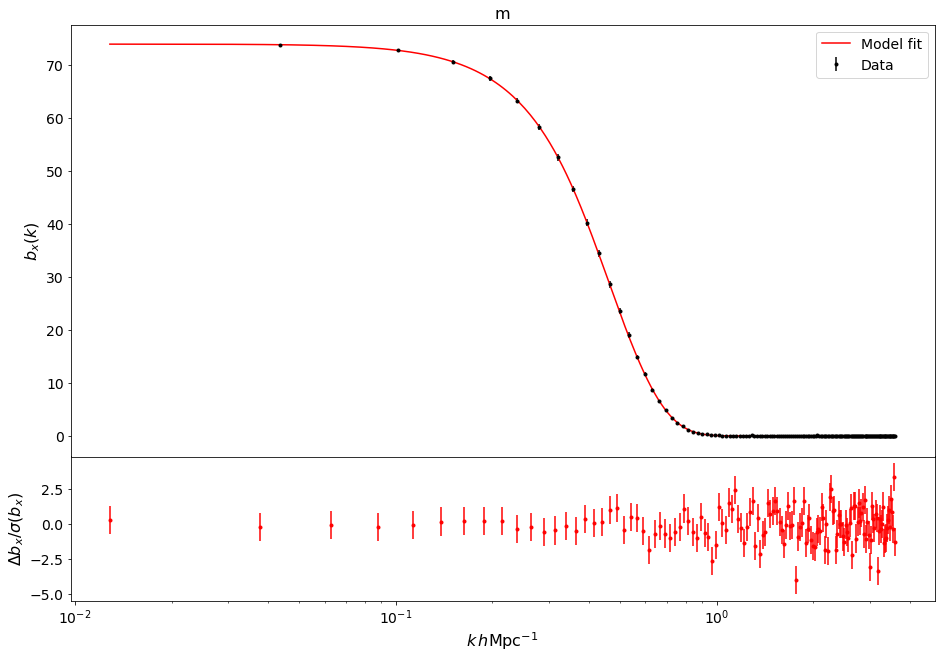

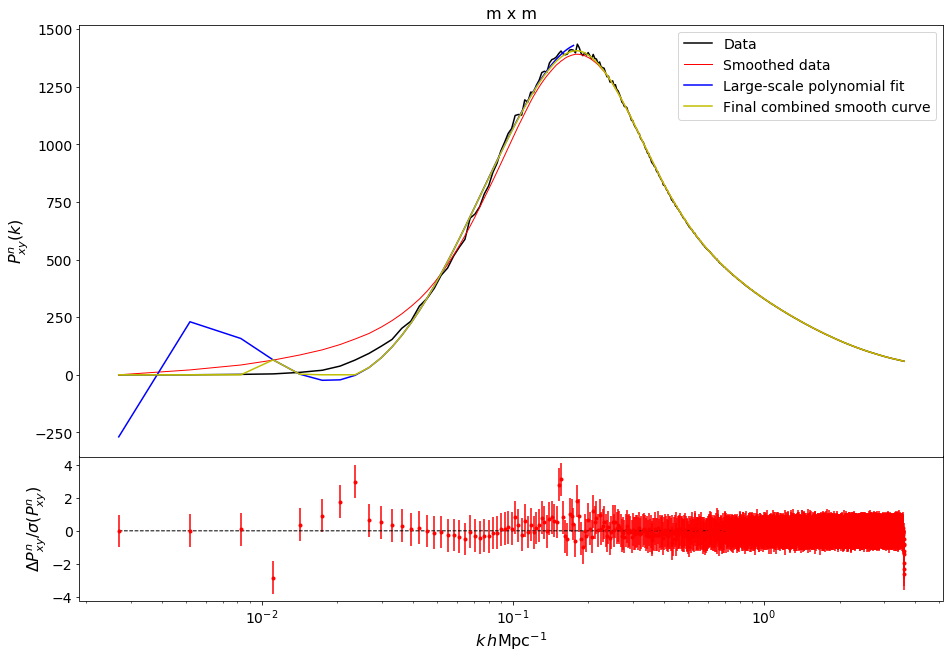

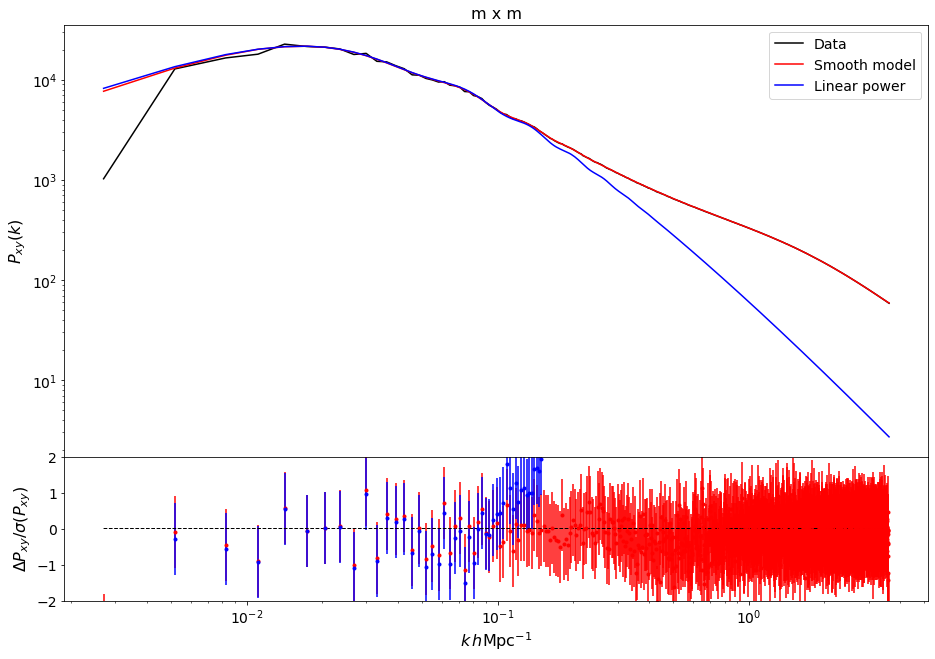

In [8]:
fitters[0].get_pk_fit('m', 'm', diagnostic_plot=True);

Compute and save all power spectra

In [9]:
def get_pk2d_abacus():
    h = cosmo['h']
    k_s = np.geomspace(1E-4, 1E2, 512)
    lk_s = np.log(k_s)
    a_s = 1./(1+zs_abacus[::-1])
    tr_combs = [('m', 'm'),
                ('red', 'red'),
                ('red', 'm'),
                ('red_AB', 'red_AB'),
                ('red_AB', 'm'),
                ('all', 'all'),
                ('all', 'm')]
    pks = {}
    for t1, t2 in tr_combs:
        pks[f'{t1}_{t2}'] = np.array([f.get_pk_fit(t1, t2, diagnostic_plot=False)(k_s/h)/h**3
                                      for f in fitters[::-1]])
    pks_ccl = np.array([ccl.nonlin_matter_power(cosmo, k_s, a)
                        for a in a_s])
    ratio = pks_ccl / pks['m_m']
    return a_s, k_s, pks, pks_ccl, ratio

In [10]:
# a_s, k_s, pks, pks_ccl, ratio = get_pk2d_abacus()
# np.savez('AbacusData/pk2d_abacus.npz', a_s=a_s, k_s=k_s, pk_ccl=pks_ccl, **pks)